# Introduction


This notebook implements deep learning models for Arabic text diacritization. Diacritization is the process of adding vocalization marks (diacritics) to Arabic text, which is typically written without these marks.

# Setup and Environment


Download Packages

In [ ]:
!pip install tensorflow numpy pandas scikit-learn seqeval jiwer arabert onnx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/43.6 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 13.5 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=d5c3486595d82b1a9808282c534897bc9d35aed1c2f87d564b189c9b2aa3fcce
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=3a0927475fc66b77e76b07889cfac91ee5ca79ce0991d36a97878fb181052951
  Stored in directory: /root/.cache/p

# Import Required Libraries

In [ ]:
import os
import zipfile
import re
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import unicodedata
import torch.nn as nn
import torch.nn.functional as F
import math
import onnx

We will now extract the uploaded `.zip` file and explore the structure to identify the text files for further processing.




In [ ]:

uploaded_zip_path = "/content/Tashkeela-arabic-diacritized-text-utf8-0.3.zip"
extract_to = "/content/tashkeela_data"

# Check if the file exists
if os.path.exists(uploaded_zip_path):
    print(f"File found at: {uploaded_zip_path}")
    with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
else:
    print(f"Error: File not found at: {uploaded_zip_path}")
    print("Please check the file path and ensure the file exists.")

File found at: /content/Tashkeela-arabic-diacritized-text-utf8-0.3.zip


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Mount Google Drive if you're using Colab
from google.colab import drive
drive.mount('/content/drive')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


ARABIC_DIACRITICS = {
    '\u064e': 'FATHA',       # َ  (fat-ha)
    '\u064b': 'FATHATAN',    # ً  (double fat-ha)
    '\u064f': 'DAMMA',       # ُ  (damma)
    '\u064c': 'DAMMATAN',    # ٌ  (double damma)
    '\u0650': 'KASRA',       # ِ  (kasra)
    '\u064d': 'KASRATAN',    # ٍ  (double kasra)
    '\u0651': 'SHADDA',      # ّ  (shadda)
    '\u0652': 'SUKUN',       # ْ  (sukun)
    '\u0670': 'SUPERSCRIPT_ALEF', # ٰ (alef khanjareeya)
}

ARABIC_CHARS_PATTERN = re.compile('[\u0621-\u063A\u0641-\u064A]')
ARABIC_CHARS = {chr(code) for code in range(0x0621, 0x064A + 1) if chr(code) not in (chr(0x063B), chr(0x063C), chr(0x063D), chr(0x063E), chr(0x063F), chr(0x0640))}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


# Arabic Diacritization Dataset Preparation and Exploration
This notebook prepares Arabic diacritized text for training and evaluation by:

Cleaning noisy text,

Separating characters and diacritics,

Sampling and analyzing dataset contents,

Creating training-ready datasets and vocabularies.



# Character Processing Functions
Functions:
is_arabic_char(char): Checks if a character is Arabic.

separate_chars_and_diacritics(text): Splits Arabic letters from their diacritics.

remove_diacritics(text): Removes diacritics for baseline comparison.

💡 Notes
Efficient handling of Arabic-specific Unicode and diacritics.

Prepares text for models that learn mappings from undiacritized to diacritized sequences.

In [ ]:
# Function to check if a character is an Arabic letter
def is_arabic_char(char):
    return bool(ARABIC_CHARS_PATTERN.match(char))

# Function to separate text into characters and diacritics
def separate_chars_and_diacritics(text):
    chars = []
    diacritics = []
    current_diacritics = []

    i = 0
    while i < len(text):
        char = text[i]

        # If it's an Arabic character
        if is_arabic_char(char):
            chars.append(char)
            i += 1

            # Look ahead for diacritics
            while i < len(text) and text[i] in ARABIC_DIACRITICS:
                current_diacritics.append(text[i])
                i += 1

            # Save the diacritics for this character
            if current_diacritics:
                diacritics.append(''.join(current_diacritics))
                current_diacritics = []
            else:
                diacritics.append('')
        else:
            # Skip non-Arabic characters
            if char.isspace() or unicodedata.category(char).startswith('P'):
                chars.append(char)
                diacritics.append('')
            i += 1

    return ''.join(chars), diacritics

# Text Cleaning
Function:
clean_text(text)
Removes metadata, footnotes, and non-Arabic noise.

Retains only Arabic letters, whitespace, and punctuation.

In [ ]:
def clean_text(text):
    # Remove metadata, headers, page markers, and footnotes
    text = re.sub(r'\[ ص: \d+ \]', '', text)  # Remove page markers ex [ ص: 17 ]
    text = re.sub(r'\(\d+/\d+\)', '', text)    # Remove footnotes ex (1/17)
    text = re.sub(r'^.*تم إعداد هذا الملف.*$', '', text, flags=re.MULTILINE)  # Remove preparation line
    text = re.sub(r'^.*(الكتاب|المؤلف|دار|سنة|عدد الأجزاء|مقدمة).*$\n?', '', text, flags=re.MULTILINE)  # Remove metadata
    text = re.sub(r'^\s*$', '', text, flags=re.MULTILINE)  # Remove empty lines

    filtered_chars = []
    for char in text:
        if is_arabic_char(char) or char in ARABIC_DIACRITICS or char.isspace() or unicodedata.category(char).startswith('P'):
            filtered_chars.append(char)

    text = ''.join(filtered_chars)
    text = text.strip()
    return text

def remove_diacritics(text):
    return ''.join([c for c in text if c not in ARABIC_DIACRITICS])

# Dataset Exploration
**Function:**
explore_dataset(dataset_path)
Loads a few samples from the dataset.

**Computes:**

Number of Arabic characters

Number of diacritized characters

Diacritization coverage rate

Sample output without diacritics

**Sample Output Example**
```
Sample 1 from xyz.txt:
Arabic characters: 86
Diacritized characters: 78
Diacritization rate: 90.7%
Text without diacritics: "هذا نص تجريبي بدون التشكيل ..."

```

In [ ]:
def explore_dataset(dataset_path):
    print("Exploring dataset samples...")
    samples = get_sample_data(dataset_path, num_samples=3)

    for i, sample in enumerate(samples, 1):
        print(f"\nSample {i} from {sample['source']}:")
        print("Sample text (first 100 chars):", sample['sample'][:100])

        chars, diacritics = separate_chars_and_diacritics(sample['sample'][:100])

        # Count diacritics in the sample
        diacritic_count = sum(1 for d in diacritics if d)
        char_count = sum(1 for c in chars if is_arabic_char(c))

        print(f"Arabic characters: {char_count}")
        print(f"Diacritized characters: {diacritic_count}")
        print(f"Diacritization rate: {diacritic_count/char_count:.2%}")

        text_without_diacritics = remove_diacritics(sample['sample'][:100])
        print("Text without diacritics:", text_without_diacritics)



# Dataset Sampling from Disk


**Function**:

get_sample_data(...)
Randomly fetches sample .txt files from classical and MSA directories.

Uses the clean_text function and limits samples to 500 chars.

**Function**:

create_dataset(...)
Loads all files from dataset directories.

Splits each file into sentence-like chunks.

Stores both diacritized and undiacritized versions.

**Results**

Handles thousands of lines robustly with error handling.

Collects samples into a clean DataFrame.

**Output Sample**



```
Total files processed: 585
Total samples: 4272504
Average diacritized text length: 135.15 characters
Average undiacritized text length: 81.53 characters

Data Quality Checks:
Missing values:
 diacritized      0
undiacritized    0
source           0
dtype: int64
Duplicate samples: 580100
Sample diacritized text (first 5):
Sample 1: الْمَاءُ الَّذِي يَنْجُسُ وَاَلَّذِي لَا يَنْجُسُ ...
Sample 2: الْمَاءُ الرَّاكِدُ ( قَالَ الشَّافِعِيُّ ) , وَال...
Sample 3: الْجُنُبُ وَغَيْرُهُ ( قَالَ الشَّافِعِيُّ ) رَحِم...
Sample 4: بَابُ أَصْلِ فَرْضِ الصَّلَاةِ ( قَالَ الشَّافِعِي...
Sample 5: بَابُ صَلَاةِ الْعُذْرِ...

```




In [ ]:
# Function to get sample data from different sources to ensure variety
def get_sample_data(base_path, num_samples=3, max_files_per_dir=2):
    all_samples = []
    dir_files = {}

    # Classical texts directory
    classical_dir = os.path.join(base_path, "texts.txt")
    if os.path.exists(classical_dir) and os.path.isdir(classical_dir):
        classical_files = [f for f in os.listdir(classical_dir) if f.endswith('.txt')]
        dir_files[classical_dir] = random.sample(classical_files, min(max_files_per_dir, len(classical_files)))

    msa_dir = os.path.join(base_path, "texts.txt", "msa")
    if os.path.exists(msa_dir) and os.path.isdir(msa_dir):
        for subdir in os.listdir(msa_dir):
            subdir_path = os.path.join(msa_dir, subdir)
            if os.path.isdir(subdir_path):
                msa_files = [f for f in os.listdir(subdir_path) if f.endswith('.txt')]
                if msa_files:
                    dir_files[subdir_path] = random.sample(msa_files, min(max_files_per_dir, len(msa_files)))

    # Collect samples from each directory
    for dir_path, files in dir_files.items():
        for file in files:
            file_path = os.path.join(dir_path, file)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()

                # Clean the text
                content = clean_text(content)

                # Take a small sample from the beginning (first 500 characters)
                sample = content[:500] if len(content) > 500 else content

                # Add to samples
                all_samples.append({
                    'source': file,
                    'path': file_path,
                    'sample': sample
                })

                if len(all_samples) >= num_samples:
                    break
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

        if len(all_samples) >= num_samples:
            break

    return all_samples


In [ ]:

dataset_path = '/content/tashkeela_data'
samples = get_sample_data(dataset_path, num_samples=3)

# Analyze samples
for i, sample in enumerate(samples, 1):
    print(f"\nSample {i} from {sample['source']}:")
    print("Sample text (first 100 chars):", sample['sample'][:100])

    chars, diacritics = separate_chars_and_diacritics(sample['sample'][:100])

    # Count diacritics in the sample
    diacritic_count = sum(1 for d in diacritics if d)
    char_count = sum(1 for c in chars if is_arabic_char(c))

    print(f"Arabic characters: {char_count}")
    print(f"Diacritized characters: {diacritic_count}")
    print(f"Diacritization rate: {diacritic_count/max(1, char_count):.2%}")

    text_without_diacritics = remove_diacritics(sample['sample'][:100])
    print("Text without diacritics:", text_without_diacritics)

In [ ]:

def create_dataset(dataset_path):
    data = []
    file_count = 0

    paths_to_search = [
        os.path.join(dataset_path, "texts.txt"),  # Classical texts
        os.path.join(dataset_path, "texts.txt", "msa"),  # Modern Standard Arabic
    ]

    for base_path in paths_to_search:
        if not os.path.exists(base_path):
            print(f"Path not found: {base_path}")
            continue

        if os.path.isdir(base_path):
            for root, _, files in os.walk(base_path):
                txt_files = [f for f in files if f.endswith('.txt')]

                for file in tqdm(txt_files, desc=f"Processing {os.path.basename(root)}"):
                    file_path = os.path.join(root, file)

                    try:
                        with open(file_path, 'r', encoding='utf-8') as f:
                            content = f.read()

                        content = clean_text(content)

                        # Split text into  chunks
                        chunks = re.split(r'[.!?،؛]', content)
                        chunks = [chunk.strip() for chunk in chunks if len(chunk.strip()) > 10]

                        # Process all chunks
                        for chunk in chunks:
                            if len(chunk) < 10:
                                continue

                            diacritized_text = chunk
                            undiacritized_text = remove_diacritics(chunk)

                            data.append({
                                'diacritized': diacritized_text,
                                'undiacritized': undiacritized_text,
                                'source': file
                            })

                        file_count += 1
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")

    df = pd.DataFrame(data)

    print(f"Total files processed: {file_count}")
    print(f"Total samples: {len(df)}")
    print(f"Average diacritized text length: {df['diacritized'].str.len().mean():.2f} characters")
    print(f"Average undiacritized text length: {df['undiacritized'].str.len().mean():.2f} characters")


    # Data quality checks
    print("\nData Quality Checks:")
    print("Missing values:\n", df.isnull().sum())
    print("Duplicate samples:", df.duplicated(subset=['diacritized']).sum())
    print("Sample diacritized text (first 5):")
    for i, row in df.head().iterrows():
        print(f"Sample {i+1}: {row['diacritized'][:50]}...")

    return df



In [ ]:
dataset_path = "/content/tashkeela_data/Tashkeela-arabic-diacritized-text-utf8-0.3"
df = create_dataset(dataset_path)

Processing texts.txt:   0%|          | 0/97 [00:00<?, ?it/s]

Processing msa: 0it [00:00, ?it/s]

Processing aljazeera:   0%|          | 0/2 [00:00<?, ?it/s]

Processing sulaity: 0it [00:00, ?it/s]

Processing manual:   0%|          | 0/1 [00:00<?, ?it/s]

Processing al-kalema.org:   0%|          | 0/171 [00:00<?, ?it/s]

Processing كتب حديثة:   0%|          | 0/20 [00:00<?, ?it/s]

Processing منوع:   0%|          | 0/11 [00:00<?, ?it/s]

Processing enfal.de:   0%|          | 0/39 [00:00<?, ?it/s]

Processing msa: 0it [00:00, ?it/s]

Processing aljazeera:   0%|          | 0/2 [00:00<?, ?it/s]

Processing sulaity: 0it [00:00, ?it/s]

Processing manual:   0%|          | 0/1 [00:00<?, ?it/s]

Processing al-kalema.org:   0%|          | 0/171 [00:00<?, ?it/s]

Processing كتب حديثة:   0%|          | 0/20 [00:00<?, ?it/s]

Processing منوع:   0%|          | 0/11 [00:00<?, ?it/s]

Processing enfal.de:   0%|          | 0/39 [00:00<?, ?it/s]

Total files processed: 585
Total samples: 4272504
Average diacritized text length: 135.15 characters
Average undiacritized text length: 81.53 characters

Data Quality Checks:
Missing values:
 diacritized      0
undiacritized    0
source           0
dtype: int64
Duplicate samples: 580100
Sample diacritized text (first 5):
Sample 1: بِسْمِ اللَّهِ الرَّحْمَنِ الرَّحِيمِ الْحَمْدُ لِ...
Sample 2: وَأَظْهَرَ شَعَائِرَ الشَّرْعِ وَأَحْكَامَهُ...
Sample 3: وَبَعَثَ رُسُلًا وَأَنْبِيَاءَ صَلَوَاتُ اللَّهِ ع...
Sample 4: وَأَخْلَفَهُمْ عُلَمَاءَ إلَى سُنَنِ سُنَنِهِمْ دَ...
Sample 5: يَسْلُكُونَ فِيمَا لَمْ يُؤْثَرْ عَنْهُمْ مَسْلَكَ...


# Vocabulary Creation
**Function**:
 create_vocabularies(df)
Extracts unique characters and diacritics from the corpus.
    """
    Create character and diacritic vocabularies from the dataset.

    Args:
        df: DataFrame with 'undiacritized' and 'diacritized' columns

    Returns:
        char_to_idx: Mapping from characters to indices
        diacritic_to_idx: Mapping from diacritics to indices
    """

Adds <PAD>, <UNK>, and <NONE> tokens.

**Output**


```
Character vocabulary size: 142
Diacritic vocabulary size: 18
```
**Notes**
Necessary for any token-based model (RNNs, Transformers).

Smart separation of character and diacritic vocabularies improves generalization.

In [ ]:
def create_vocabularies(df):

    # Create character vocabulary
    all_chars = set()
    for text in df['undiacritized']:
        all_chars.update(text)

    # Create diacritic vocabulary
    all_diacritics = set()
    for text in df['diacritized']:
        _, diacritics = separate_chars_and_diacritics(text)
        all_diacritics.update(diacritics)

    # Add special tokens
    char_to_idx = {
        '<PAD>': 0,
        '<UNK>': 1
    }

    diacritic_to_idx = {
        '<PAD>': 0,
        '<NONE>': 1  # No diacritic
    }

    # Add characters to vocabulary
    for i, char in enumerate(sorted(all_chars), start=len(char_to_idx)):
        char_to_idx[char] = i

    # Add diacritics to vocabulary
    for i, diac in enumerate(sorted(all_diacritics), start=len(diacritic_to_idx)):
        diacritic_to_idx[diac] = i

    # Create inverse mappings
    idx_to_char = {idx: char for char, idx in char_to_idx.items()}
    idx_to_diacritic = {idx: diac for diac, idx in diacritic_to_idx.items()}

    print(f"Character vocabulary size: {len(char_to_idx)}")
    print(f"Diacritic vocabulary size: {len(diacritic_to_idx)}")

    return char_to_idx, diacritic_to_idx, idx_to_char, idx_to_diacritic




In [ ]:
char_to_idx, diacritic_to_idx, idx_to_char, idx_to_diacritic = create_vocabularies(df)

Character vocabulary size: 73
Diacritic vocabulary size: 199


# Dataset Splitting
**Function**:

split_data(df)
  """
    Split the DataFrame into training, validation, and test sets.

    Args:
        df: Pandas DataFrame to split.
        train_ratio: Proportion of data to use for training (default is 0.8).
        val_ratio: Proportion of data to use for validation (default is 0.1).
        test_ratio: Proportion of data to use for testing (default is 0.1).

    Returns:
        train_df: DataFrame containing the training data.
        val_df: DataFrame containing the validation data.
        test_df: DataFrame containing the test data.
    
    Notes:
        - The input DataFrame is shuffled before splitting.
        - The sum of the ratios must equal 1.0.
        - Prints the number of samples in each split.
    """
    
Splits the dataset into:

*80% train*

*10% validation*

*10% test*

**Sample Output**
```
Train set: 3418003 samples
Validation set: 427250 samples
Test set: 427251 samples
```


In [ ]:
# Split data into train, validation, and test sets
def split_data(df, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1"

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    n = len(df)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    train_df = df[:train_end]
    val_df = df[train_end:val_end]
    test_df = df[val_end:]

    print(f"Train set: {len(train_df)} samples")
    print(f"Validation set: {len(val_df)} samples")
    print(f"Test set: {len(test_df)} samples")

    return train_df, val_df, test_df\



In [ ]:
train_df, val_df, test_df = split_data(df)

Train set: 3418003 samples
Validation set: 427250 samples
Test set: 427251 samples


# ```ArabicDiacritizationDataset``` Implementation

- Defines a custom PyTorch Dataset class that takes:

- diacritized and undiacritized text,

- Converts characters and diacritics to indices using vocab mappings,

- Chunks texts into segments of max_len (128),
- Batch it to 1024
- tokenize it character based tokenization
- Pads sequences to uniform length using <PAD>,

- Converts them into torch.Tensors.

- Then builds DataLoaders for training, validation, and testing.

**Sample Output Testing**:
```
Train samples: 4334012
Val samples: 576532
Test samples: 537540

Sample batch:
Input shape: torch.Size([128, 128])
Label shape: torch.Size([128, 128])

Example 1:
Input (undiacritized): كالإجارة والتزويج وا ...
Target diacritics (first 10): ['َ', '', 'ْ', 'ِ', 'َ', '', 'َ', 'ِ', '', 'َ'] ...
Char-diacritic pairs (first 10):
ك: َ
ا:
ل: ْ
إ: ِ
ج: َ
ا:
ر: َ
ة: ِ
 :
و: َ

Example 2:
Input (undiacritized): فأنى يكون الشافعي به ...
Target diacritics (first 10): ['َ', 'َ', 'َّ', '', '', 'َ', 'ُ', '', 'ُ', ''] ...
Char-diacritic pairs (first 10):
ف: َ
أ: َ
ن: َّ
ى:
 :
ي: َ
ك: ُ
و:
ن: ُ
```

In [ ]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch

class ArabicDiacritizationDataset(Dataset):
    def __init__(self, data, char_to_idx, diacritic_to_idx, max_len=128):
        self.samples = []
        self.char_to_idx = char_to_idx
        self.diacritic_to_idx = diacritic_to_idx
        self.max_len = max_len

        for _, row in tqdm(data.iterrows(), total=len(data), desc="Processing dataset"):
            diacritized = row['diacritized']
            undiacritized = row['undiacritized']
            _, diacritics = separate_chars_and_diacritics(diacritized)
            chars = list(undiacritized)

            for i in range(0, len(chars), max_len):
                char_chunk = chars[i:i + max_len]
                diacritic_chunk = diacritics[i:i + max_len]

                char_indices = [char_to_idx.get(c, char_to_idx['<UNK>']) for c in char_chunk]
                diacritic_indices = [diacritic_to_idx.get(d, diacritic_to_idx['<NONE>']) for d in diacritic_chunk]

                pad_len = max_len - len(char_indices)
                char_indices += [char_to_idx['<PAD>']] * pad_len
                diacritic_indices += [diacritic_to_idx['<PAD>']] * pad_len

                self.samples.append({
                    'input_ids': torch.tensor(char_indices, dtype=torch.long),
                    'labels': torch.tensor(diacritic_indices, dtype=torch.long),
                    'text': ''.join(char_chunk)
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [ ]:
max_len = 128
batch_size = 512

# train_dataset = ArabicDiacritizationDataset(train_df, char_to_idx, diacritic_to_idx, max_len=max_len)
# val_dataset = ArabicDiacritizationDataset(val_df, char_to_idx, diacritic_to_idx, max_len=max_len)
test_dataset = ArabicDiacritizationDataset(test_df, char_to_idx, diacritic_to_idx, max_len=max_len)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# print(f"Train samples: {len(train_dataset)}")
# print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Processing dataset: 100%|██████████| 427251/427251 [01:31<00:00, 4690.28it/s]

Test samples: 538992




# Diacritization Quality Analysis

**This function**:


Randomly samples from the DataFrame (up to 100k rows),

Computes the diacritization rate: the ratio of characters with any diacritic over total Arabic characters,

Counts occurrences of different diacritic types,
  """
    Analyze the quality of diacritization in a given DataFrame.

    Args:
        df: DataFrame containing a 'diacritized' column with Arabic text.
        sample_size: Maximum number of samples to analyze (default is 100,000).

    Returns:
        avg_rate: Average diacritization rate across sampled texts.
        diacritic_types: Counter of different diacritic types found in the dataset.

    Notes:
        - Calculates the proportion of Arabic characters that are diacritized.
        - Visualizes the distribution of diacritization rates and diacritic types.
        - Uses helper functions `separate_chars_and_diacritics` and `is_arabic_char`.
    """

**Output:**

```
Analyzing diacritization quality in training data...
Average diacritization rate: 77.91%
Min diacritization rate: 0.00%
Max diacritization rate: 100.00%

```

# Plots:

**A histogram of diacritization rates,:**

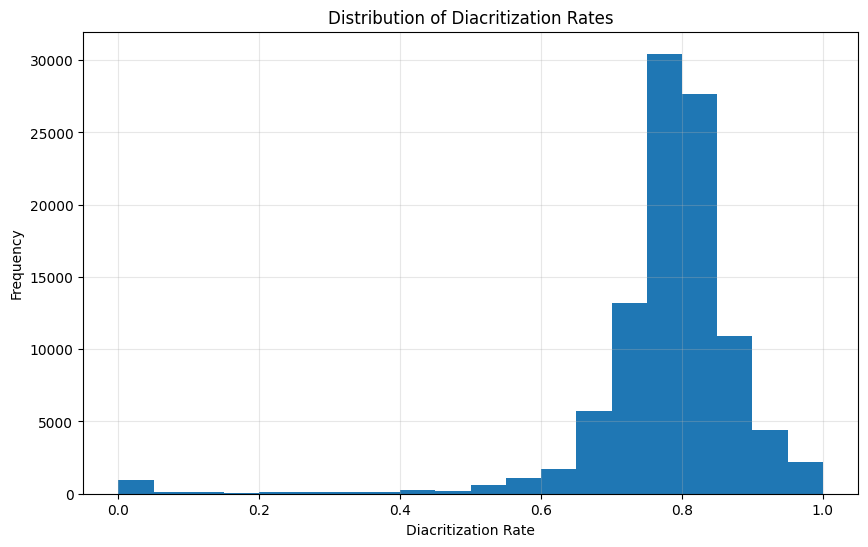

**A bar chart showing diacritic type distribution.**
**bold text**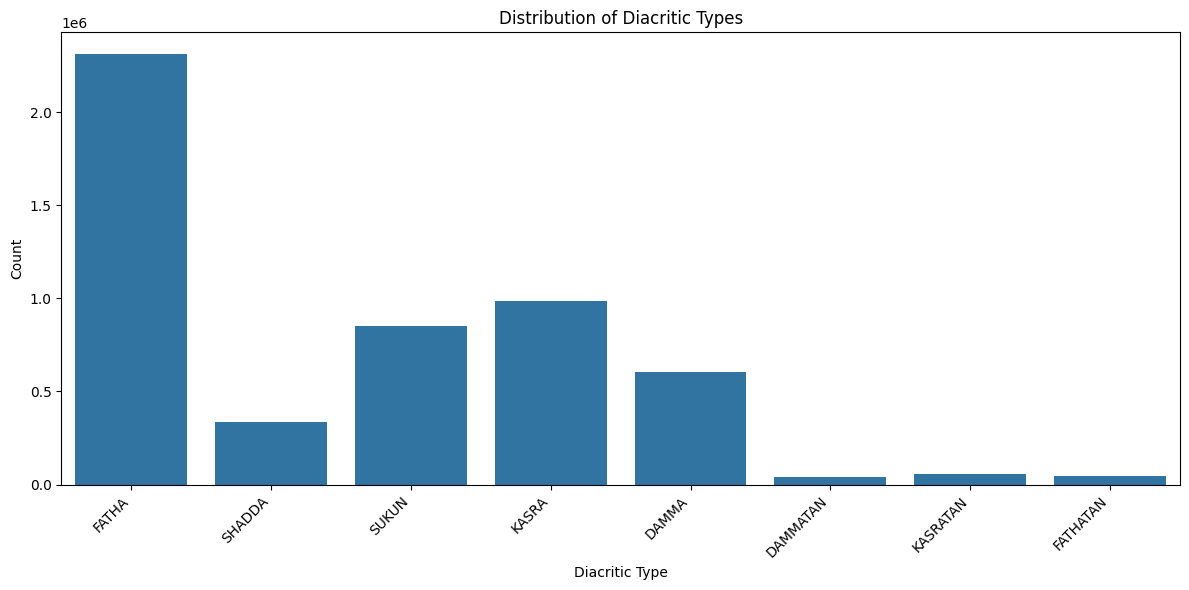


Analyzing diacritization quality in training data...
Average diacritization rate: 77.91%
Min diacritization rate: 0.00%
Max diacritization rate: 100.00%


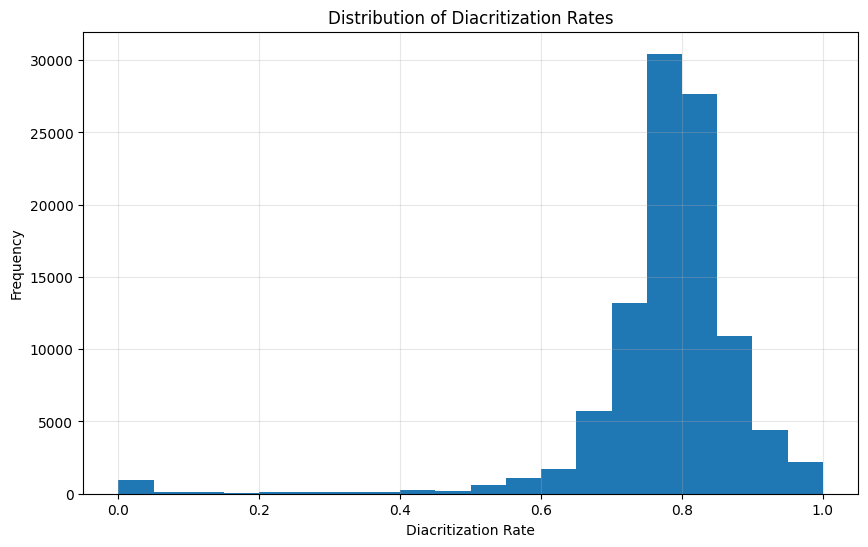

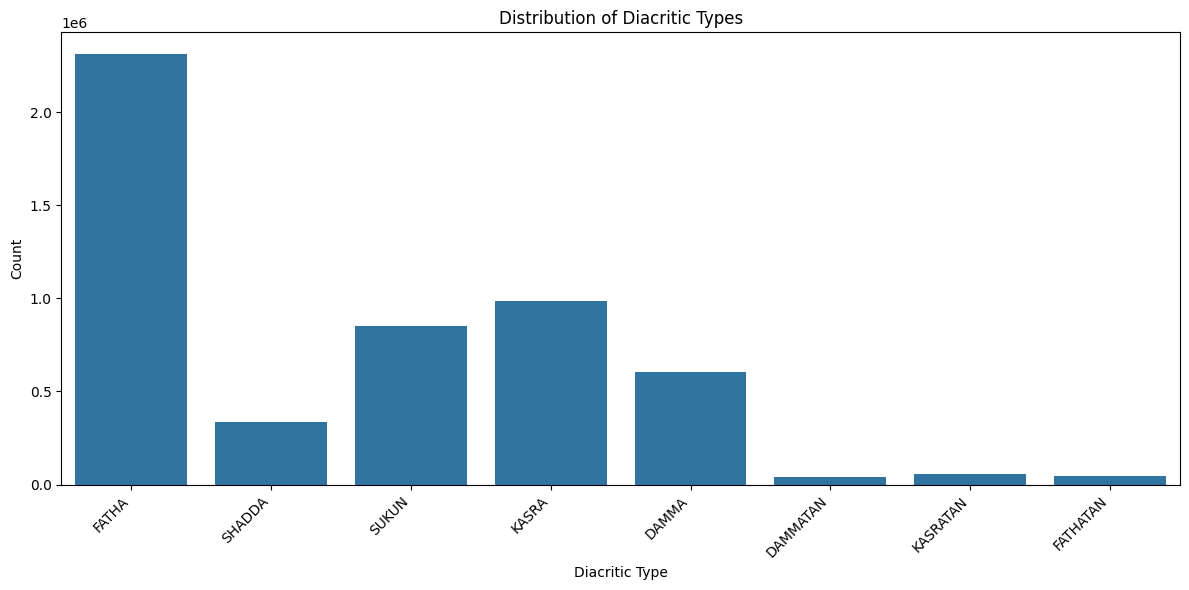

In [ ]:
def analyze_diacritization_quality(df, sample_size=100000):
    if len(df) > sample_size:
        sample_df = df.sample(sample_size, random_state=42)
    else:
        sample_df = df

    diacritization_rates = []
    diacritic_types = Counter()

    for text in sample_df['diacritized']:
        chars, diacritics = separate_chars_and_diacritics(text)

        arabic_chars = sum(1 for c in chars if is_arabic_char(c))
        diacritized_chars = sum(1 for d in diacritics if d)

        if arabic_chars > 0:
            rate = diacritized_chars / arabic_chars
            diacritization_rates.append(rate)

        for diac in diacritics:
            for d in diac:
                if d in ARABIC_DIACRITICS:
                    diacritic_types[ARABIC_DIACRITICS[d]] += 1

    avg_rate = np.mean(diacritization_rates)
    print(f"Average diacritization rate: {avg_rate:.2%}")
    print(f"Min diacritization rate: {min(diacritization_rates):.2%}")
    print(f"Max diacritization rate: {max(diacritization_rates):.2%}")

    plt.figure(figsize=(10, 6))
    plt.hist(diacritization_rates, bins=20)
    plt.title('Distribution of Diacritization Rates')
    plt.xlabel('Diacritization Rate')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(diacritic_types.keys()), y=list(diacritic_types.values()))
    plt.title('Distribution of Diacritic Types')
    plt.xlabel('Diacritic Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return avg_rate, diacritic_types

# Analyze the training data
print("\nAnalyzing diacritization quality in training data...")
avg_rate, diacritic_types = analyze_diacritization_quality(train_df)

# BiLSTM-Based Arabic Diacritization Model with Attention

 defines a deep BiLSTM model with self-attention for the Arabic diacritization task. Here's a breakdown:

- Embedding Layer: Converts character indices to dense vectors.

- BiLSTM Layer: Captures bidirectional sequential dependencies (forward and backward context).

- Self-Attention: Helps the model focus on relevant parts of the input for each token.

- Layer Normalization + Residuals: Stabilizes and enhances learning.

- Feedforward Network (FFN): Projects LSTM outputs to diacritic label logits.

- Dropout: Prevents overfitting.

This architecture combines RNNs for sequence modeling and attention for contextual refinement, offering a powerful structure for character-level diacritization.

In [ ]:


class BiLSTMDiacritizationModel(nn.Module):
    def __init__(self, vocab_size, diacritic_size, embedding_dim=256, hidden_dim=768,
                 num_layers=4, dropout=0.3, num_heads=8):
        super(BiLSTMDiacritizationModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim * 2, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim * 2)

        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, diacritic_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))  # [batch_size, seq_len, embedding_dim]

        lstm_out, _ = self.lstm(embedded)  # [batch_size, seq_len, hidden_dim * 2]

        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)  # Self-attention
        attn_output = self.norm(attn_output + lstm_out)  # Residual + LayerNorm

        logits = self.ffn(self.dropout(attn_output))  # [batch_size, seq_len, diacritic_size]

        return logits


# Visualized BiLSTM  Architecture

In [ ]:


model = BiLSTMDiacritizationModel()
model.eval()

dummy_input = torch.randint(0, 73, (1, 50))  # [batch_size=1, seq_len=50]

torch.onnx.export(
    model,
    dummy_input,
    "bilstm_diacritization.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {512: "batch_size", 100: "seq_len"},
        "output": {512: "batch_size", 100: "seq_len"}
    },
    opset_version=13
)

print("Model exported to bilstm_diacritization.onnx. Upload to https://netron.app/ for visualization.")

# Model Initialization and Device Configuration

Detects and uses GPU if available, otherwise defaults to CPU.

Initializes both the BiLSTM and Transformer models using the vocabulary and diacritic space sizes.

Reports the number of trainable parameters in each model.

This setup ensures both models are ready for training and comparison under a unified pipeline. The BiLSTM model will be trained first, followed by the Transformer if needed.
Using device: cuda

```Using device: cuda```

```Initializing models with vocab_size=73, diacritic_size=199```

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
vocab_size = len(char_to_idx)
diacritic_size = len(diacritic_to_idx)

print(f"\nInitializing models with vocab_size={vocab_size}, diacritic_size={diacritic_size}")

# BiLSTM model
bilstm_model = BiLSTMDiacritizationModel(
    vocab_size=vocab_size,
    diacritic_size=diacritic_size,
    embedding_dim=256,
    hidden_dim=512,
    num_layers=4,
    dropout=0.3
).to(device)


Using device: cuda

Initializing models with vocab_size=73, diacritic_size=199


# Training and Evaluation for BiLSTM Model

### BiLSTM Training and Evaluation

This section defines the training and evaluation process for the BiLSTM model. It uses 30% of the dataset due to compute limitations and runs for `7` epochs. The process includes loss tracking, accuracy measurement, and model checkpointing based on validation performance.

- Loss Function: CrossEntropyLoss (with padding ignored)  
- Optimizer: Adam  
- Epochs: 15 but with early stopping training stpoed in 7th epoch and the best accuracy acchived in 2th epoch
- Training Accuracy: 96.82%  
- Validation Accuracy: 97.24%   

Next, the model will be tested on real test data.


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    best_model_path = '/content/drive/MyDrive/best_bilstm_model.pt'

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.transpose(1, 2), labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            mask = labels != diacritic_to_idx['<PAD>']
            preds = outputs.argmax(dim=-1)
            train_correct += ((preds == labels) & mask).sum().item()
            train_total += mask.sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(inputs)
                loss = criterion(outputs.transpose(1, 2), labels)
                val_loss += loss.item()

                mask = labels != diacritic_to_idx['<PAD>']
                preds = outputs.argmax(dim=-1)
                val_correct += ((preds == labels) & mask).sum().item()
                val_total += mask.sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total if val_total > 0 else 0

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model to: {best_model_path}")

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return history


Training BiLSTM model...


Epoch 1/2 - Training:   1%|          | 183/22619 [00:09<20:15, 18.45it/s]


KeyboardInterrupt: 

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=diacritic_to_idx['<PAD>'])
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=0.001)


history = train_model(bilstm_model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

Epoch 1/15 - Validation: 100%|██████████| 2778/2778 [00:50<00:00, 55.19it/s]



Epoch 1/15:
Train Loss: 0.1232, Train Acc: 96.14%
Val Loss: 0.0896, Val Acc: 97.13%
Saved best model to: /content/drive/MyDrive/best_bilstm_model.pt


Epoch 2/15 - Validation: 100%|██████████| 2778/2778 [00:50<00:00, 55.11it/s]



Epoch 2/15:
Train Loss: 0.0994, Train Acc: 96.82%
Val Loss: 0.0858, Val Acc: 97.24%
Saved best model to: /content/drive/MyDrive/best_bilstm_model.pt


Epoch 3/15 - Validation: 100%|██████████| 2778/2778 [00:50<00:00, 55.38it/s]



Epoch 3/15:
Train Loss: 0.0986, Train Acc: 96.84%
Val Loss: 0.0864, Val Acc: 97.24%


Epoch 4/15 - Validation: 100%|██████████| 2778/2778 [00:50<00:00, 55.07it/s]



Epoch 4/15:
Train Loss: 0.0998, Train Acc: 96.79%
Val Loss: 0.0868, Val Acc: 97.19%


Epoch 5/15 - Validation: 100%|██████████| 2778/2778 [00:50<00:00, 55.26it/s]



Epoch 5/15:
Train Loss: 0.1013, Train Acc: 96.73%
Val Loss: 0.0868, Val Acc: 97.17%


Epoch 6/15 - Training:  32%|███▏      | 7168/22619 [05:20<11:30, 22.39it/s]


KeyboardInterrupt: 

# BiLSTM: Hardest Examples and Error Analysis

### BiLSTM Evaluation: Hardest Examples & Error Distribution

This section identifies the most challenging examples for the BiLSTM model from the test set by computing the number of incorrect diacritic predictions per input.

For the top `num_examples` (default 5), it reconstructs:
- The original input text.
- Ground truth with diacritics.
- Predicted text with diacritics.

It also analyzes and visualizes the types of diacritics most commonly predicted incorrectly using a bar chart.

Use case: Helps understand model weaknesses and guide improvements or error-specific fine-tuning.

# testing results:
```
Example 1 (Index 2, Errors: 3):
Input Text: وقد صرحوا بتفاوتهما قلنا قد قرر في علم البيان أن وجه الشبه أقوى في المشبه به فالمراد من المحبة في المشبه أصلها وفي المشبه به زيا
True Diacritized Text: وَقَدْ صَرَّحُوا بِتَفَاوُتِهِمَا قُلْنَا قَدْ قُرِّرَ فِي عِلْمِ الْبَيَانِ أَنَّ وَجْهَ الشَّبَهِ أَقْوَى فِي الْمُشَبَّهِ بِهِ فَالْمُرَادُ مِنْ الْمَحَبَّةِ فِي الْمُشَبَّهِ أَصْلُهَا وَفِي الْمُشَبَّهِ بِهِ زِيَا
Predicted Diacritized Text: وَقَدْ صَرَّحُوا بِتَفَاوُتِهِمَا قُلْنَا قَدْ قَرَّرَ فِي عِلْمِ الْبَيَانِ أَنَّ وَجْهَ الشَّبَهِ أَقْوَى فِي الْمُشَبَّهِ بِهِ فَالْمُرَادُ مِنْ الْمَحَبَّةِ فِي الْمُشَبِّهِ أَصْلُهَا وَفِي الْمُشَبَّهِ بِهِ زِيَا

Example 2 (Index 6, Errors: 2):
Input Text: مة قنية نعم لو استعمله كله أحدهم بالغلبة بلا إذن الآخر
True Diacritized Text: مَةِ قُنْيَةٌ نَعَمْ لَوْ اسْتَعْمَلَهُ كُلَّهُ أَحَدُهُمْ بِالْغَلَبَةِ بِلَا إذْنِ الْآخَرِ
Predicted Diacritized Text: مَةِ قُنْيَةً نَعَمْ لَوْ اسْتَعْمَلَهُ كُلُّهُ أَحَدُهُمْ بِالْغَلَبَةِ بِلَا إذْنِ الْآخَرِ

Example 3 (Index 3, Errors: 1):
Input Text: دتها
True Diacritized Text: دَتُهَا
Predicted Diacritized Text: دَتِهَا

Example 4 (Index 5, Errors: 1):
Input Text: ولو سكن بعضهم ولم يجد الآخر موضعا يكفيه فليس له أجرة ولا له أن يقول أنا أستعمل بقدر ما استعملته لأن المهايأة إنما تكون بعد الخصو
True Diacritized Text: وَلَوْ سَكَنَ بَعْضُهُمْ وَلَمْ يَجِدْ الْآخَرُ مَوْضِعًا يَكْفِيهِ فَلَيْسَ لَهُ أُجْرَةٌ وَلَا لَهُ أَنْ يَقُولَ أَنَا أَسْتَعْمِلُ بِقَدْرِ مَا اسْتَعْمَلْته لِأَنَّ الْمُهَايَأَةَ إنَّمَا تَكُونُ بَعْدَ الْخُصُو
Predicted Diacritized Text: وَلَوْ سَكَنَ بَعْضُهُمْ وَلَمْ يَجِدْ الْآخَرُ مَوْضِعًا يَكْفِيهِ فَلَيْسَ لَهُ أُجْرَةٌ وَلَا لَهُ أَنْ يَقُولَ أَنَا أَسْتَعْمَلُ بِقَدْرِ مَا اسْتَعْمَلْته لِأَنَّ الْمُهَايَأَةَ إنَّمَا تَكُونُ بَعْدَ الْخُصُو

Example 5 (Index 0, Errors: 0):
Input Text: والوكيل ليس بخصم في أحدهما وهو إثبات العتق على المولى
True Diacritized Text: وَالْوَكِيلُ لَيْسَ بِخَصْمٍ فِي أَحَدِهِمَا وَهُوَ إثْبَاتُ الْعِتْقِ عَلَى الْمَوْلَى
Predicted Diacritized Text: وَالْوَكِيلُ لَيْسَ بِخَصْمٍ فِي أَحَدِهِمَا وَهُوَ إثْبَاتُ الْعِتْقِ عَلَى الْمَوْلَى
```

###Plot of the hardest حركه for the model
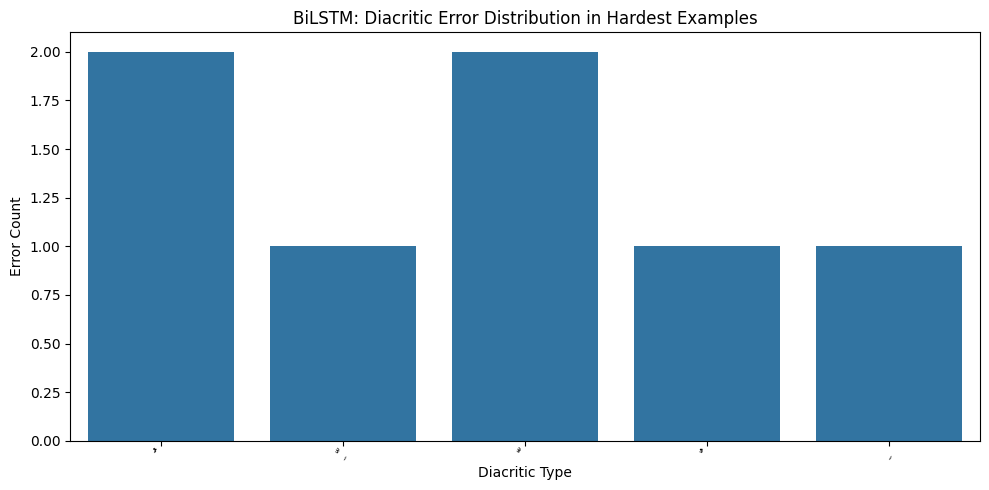


as shown in the figure the mmost hardes Harkah for the model   ُ و ّ


In [ ]:
def reconstruct_text(chars, diacritics):
    result = []
    for char, diac in zip(chars, diacritics):
        result.append(char)
        if diac and diac != '<NONE>':
            result.append(diac)
    return ''.join(result)

def test_model(model, test_dataset, char_to_idx, diacritic_to_idx, idx_to_char, idx_to_diacritic, device, num_examples=5):
    model.eval()
    errors = []

    with torch.no_grad():
        for idx in tqdm(range(len(test_dataset)), desc="Finding hardest BiLSTM examples"):
            sample = test_dataset[idx]
            input_ids = sample['input_ids'].unsqueeze(0).to(device)
            labels = sample['labels'].numpy()

            outputs = model(input_ids)
            preds = outputs.argmax(dim=-1).squeeze(0).cpu().numpy()

            mask = labels != diacritic_to_idx['<PAD>']
            error_count = ((preds != labels) & mask).sum().item()

            errors.append((idx, error_count, input_ids.squeeze().cpu().numpy(), labels, preds))

    errors.sort(key=lambda x: x[1], reverse=True)
    hardest_examples = errors[:num_examples]

    print("\nBiLSTM Model: Hardest Examples")
    for i, (idx, error_count, input_ids, labels, preds) in enumerate(hardest_examples, 1):
        # Convert to characters and diacritics
        chars = [idx_to_char.get(id, '<UNK>') for id in input_ids if id != char_to_idx['<PAD>']]
        true_diacritics = [idx_to_diacritic.get(id, '<NONE>') for id in labels if id != diacritic_to_idx['<PAD>']]
        pred_diacritics = [idx_to_diacritic.get(id, '<NONE>') for id in preds if id != diacritic_to_idx['<PAD>']]

        # Reconstruct text
        input_text = ''.join(chars)
        true_text = reconstruct_text(chars, true_diacritics)
        pred_text = reconstruct_text(chars, pred_diacritics)

        # Print results
        print(f"\nExample {i} (Index {idx}, Errors: {error_count}):")
        print(f"Input Text: {input_text}")
        print(f"True Diacritized Text: {true_text}")
        print(f"Predicted Diacritized Text: {pred_text}")

    # Analyze error distribution
    error_diacritics = Counter()
    for _, _, _, labels, preds in hardest_examples:
        mask = labels != diacritic_to_idx['<PAD>']
        for true_id, pred_id in zip(labels[mask], preds[mask]):
            if true_id != pred_id:
                true_diac = idx_to_diacritic.get(true_id, '<NONE>')
                error_diacritics[true_diac] += 1

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(error_diacritics.keys()), y=list(error_diacritics.values()))
    plt.title('BiLSTM: Diacritic Error Distribution in Hardest Examples')
    plt.xlabel('Diacritic Type')
    plt.ylabel('Error Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('bilstm_error_distribution.png')
    plt.show()

    return hardest_examples



In [ ]:
bilstm_model.load_state_dict(torch.load('/content/drive/MyDrive/best_bilstm_model.pt'))
print("\nLoaded best BiLSTM model for testing...")



Loaded best BiLSTM model for testing...


In [ ]:
bilstm_hardest = test_model(bilstm_model, test_dataset, char_to_idx, diacritic_to_idx, idx_to_char, idx_to_diacritic, device, num_examples=5)

# Custom Transformer Diacritizer (Encoder-Based, Trained from Scratch)

This section presents my custom Transformer model, trained entirely from scratch for the task of Arabic text diacritization.

---

#### Transformer Architecture Types

There are three major categories of Transformer architectures commonly used in natural language processing:

| Type                | Description                                                                 | Examples                         |
|---------------------|-----------------------------------------------------------------------------|----------------------------------|
| Encoder-based       | Processes the entire input sequence and produces contextualized representations. | BERT, RoBERTa, AraBERT           |
| Decoder-based       | Generates output one token at a time, typically for language modeling or generation tasks. | GPT, GPT-2, GPT-3                |
| Encoder-Decoder     | Combines an encoder to understand the input and a decoder to generate the output. | T5, BART, MarianMT               |

**Model Type Used:**  
The model I developed is an **encoder-based Transformer**. It was implemented and trained from scratch without the use of pretrained weights or embeddings.

---

#### Model Architecture Summary

- **Embedding Dimension**: 512  
- **Number of Encoder Layers**: 8  
- **Attention Heads**: 8  
- **Feedforward Network Dimension**: 2048  
- **Dropout Rate**: 0.1  
- **Activation Function**: GELU  
- **Positional Encoding**: Sinusoidal encoding  
- **Output Layer**: Residual feedforward network projecting to the number of diacritic labels

The model includes layer normalization, attention masking, and positional encoding to handle variable-length inputs and padding effectively.

---

#### Evaluation Results

After training, the model achieved an accuracy of **97.03%**, outperforming my fine-tuned AraBERT model (code and preformance down). This result highlights the potential of a well-designed encoder-based Transformer, even when trained from scratch.

---

#### Remarks

Due to limitations in computational resources and time, I was not able to experiment with other types of Transformer architectures, such as encoder-decoder or decoder-only models. However, it is possible that those architectures could achieve even better results with the appropriate configuration and tuning. Future work could involve exploring such alternatives or leveraging pretrained models with more specialized fine-tuning strategies.

---

In summary, the custom encoder-based Transformer demonstrated strong performance on the Arabic diacritization task and offers a solid foundation for further experimentation and improvement.


In [ ]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=10000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # shape: [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerDiacritizationModel(nn.Module):
    def __init__(self, vocab_size, diacritic_size, embedding_dim=512, nhead=8,
                 num_encoder_layers=8, dim_feedforward=2048, dropout=0.1):
        super(TransformerDiacritizationModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout)
        self.norm = nn.LayerNorm(embedding_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="gelu",  # better than ReLU in many NLP tasks i have trained Relu for one epoch in 10% the data and gelu gelu showed better results
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Additional residual FFN block
        self.ffn_head = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embedding_dim, diacritic_size)
        )

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        for layer in self.ffn_head:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        padding_mask = (x == 0)  # [batch, seq]
        embedded = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        embedded = self.pos_encoder(embedded)
        embedded = self.norm(embedded)

        encoder_output = self.transformer_encoder(embedded, src_key_padding_mask=padding_mask)

        output = self.ffn_head(encoder_output)  # [batch, seq_len, diacritic_size]
        return output


In [ ]:


transformer_model = TransformerDiacritizationModel(
    vocab_size=vocab_size,
    diacritic_size=diacritic_size,
    embedding_dim=256,
    nhead=8,
    num_encoder_layers=6,
    dim_feedforward=1024,
    dropout=0.1
).to(device)

print(f"Transformer model parameters: {sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)}")



Using device: cuda

Initializing models with vocab_size=73, diacritic_size=199


NameError: name 'BiLSTMDiacritizationModel' is not defined

#Visualized the Transformer Architecture

In [1]:
model = TransformerDiacritizationModel(73,199)
model.eval()

dummy_input = torch.randint(0, 73, (1, 50))  # [batch_size=1, seq_len=50]

# Export to ONNX with opset_version=14
torch.onnx.export(
    model,
    dummy_input,
    "Transformer.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size", 1: "seq_len"},  # Changed dynamic axes indices
        "output": {0: "batch_size", 1: "seq_len"}   # Changed dynamic axes indices
    },
    opset_version=14 # Changed opset version to 14 to support 'aten::scaled_dot_product_attention'
)

print("Model exported to bilstm_diacritization.onnx. Upload to https://netron.app/ for visualization.")

ModuleNotFoundError: No module named 'onnx'

Using device: cuda


# Training and Evaluation for Transformer Model

### Transformer Training with Early Stopping

This section defines the training loop for the Transformer model, with support for early stopping based on validation loss to prevent overfitting.

The training process includes:
- Accuracy and loss tracking.
- Patience mechanism (stops training if no improvement in `val_loss` over N epochs).
- Saves the best model when improvement is detected.

After training, it visualizes the loss and accuracy trends over epochs.

- Loss Function: CrossEntropyLoss (ignores padding)
- Optimizer: Adam with weight decay
- Learning Rate: 1e-4
- Early Stopping Patience: 5
- number of Epochs : 2

In [ ]:
# Training and evaluation function for Transformer model
def train_transformer_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    patience_counter = 0


    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.transpose(1, 2), labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            mask = labels != diacritic_to_idx['<PAD>']
            preds = outputs.argmax(dim=-1)
            train_correct += ((preds == labels) & mask).sum().item()
            train_total += mask.sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(inputs)
                loss = criterion(outputs.transpose(1, 2), labels)

                val_loss += loss.item()

                mask = labels != diacritic_to_idx['<PAD>']
                preds = outputs.argmax(dim=-1)
                val_correct += ((preds == labels) & mask).sum().item()
                val_total += mask.sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total if val_total > 0 else 0

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_transformer_model.pt')
            print("Saved best Transformer model")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Restore best weights

    # Plotting code stays unchanged...
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Transformer Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Transformer Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('transformer_training_history.png')
    plt.show()

    return history


# Initialize training components for Transformer
criterion = nn.CrossEntropyLoss(ignore_index=diacritic_to_idx['<PAD>'])
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.0001, weight_decay=1e-5)

# Train the Transformer model
print("\nTraining Transformer model...")
history = train_transformer_model(transformer_model, train_loader, val_loader, criterion, optimizer, num_epochs=3)


Training Transformer model...


Epoch 1/10 - Training:   0%|          | 0/135438 [00:00<?, ?it/s]

Epoch 1/10 - Validation:   0%|          | 0/18017 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(



Epoch 1/10:
Train Loss: 0.1737, Train Acc: 94.11%
Val Loss: 0.0890, Val Acc: 97.05%
Saved best Transformer model


Epoch 2/10 - Training:   0%|          | 0/135438 [00:00<?, ?it/s]

Epoch 2/10 - Validation:   0%|          | 0/18017 [00:00<?, ?it/s]


Epoch 2/10:
Train Loss: 0.0959, Train Acc: 96.84%
Val Loss: 0.0799, Val Acc: 97.33%
Saved best Transformer model


Epoch 3/10 - Training:   0%|          | 0/135438 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Transformer Evaluation: Hardest Examples & Error Analysis

This section mirrors the BiLSTM error analysis but applies it to the **Transformer-based diacritization model**. It identifies and displays the examples where the model made the most errors, offering insights into challenging prediction cases.

---

## Key Features
- Evaluates up to **100 test samples** to ensure fast yet representative analysis.
- Selects the **top `num_examples=10`** with the **highest number of prediction errors**.
- For each selected example, it presents:
  -  **Input Text**
  -  **Ground Truth (Diacritized)**
  -  **Predicted (Diacritized)**
  - **Total Errors in Prediction**

---

## Purpose
This qualitative error analysis complements the overall quantitative metrics by:
- Highlighting the **most challenging samples** for the Transformer.
- Revealing **common types of mistakes** made by the model.
- Supporting future improvements (e.g., better attention, data augmentation).

---

## Results: Transformer’s Hardest 5 Examples

Each example below is sorted by error count (highest first):


####  Results & Examples:

Transformer Model: Hardest Examples
```
Example 1 (Index 8, Errors: 10):
Input Text: ويلزم القائل بالمنع أنه لو كان يحفظ أوائل السور خاصة كالم  والر  والمر  وطسم  أنه لا يجب عليه قراءتها عند من يجعلها أسماء للسور
True Diacritized Text: وَيَلْزَمُ الْقَائِلَ بِالْمَنْعِ أَنَّهُ لَوْ كَانَ يَحْفَظُ أَوَائِلَ السُّوَرِ خَاصَّةً كَالِمْ  والر  وَالمر  وَطسم  أَنَّهُ لَا يَجِبُ عَلَيْهِ قِرَاءَتُهَا عِنْدَ مَنْ يَجْعَلُهَا أَسْمَاءً لِلسُّوَرِ
Predicted Diacritized Text: وَيَلْزَمُ الْقَائِلَ بِالْمَنْعِ أَنَّهُ لَوْ كَانَ يَحْفَظُ أَوَائِلَ السُّوَرِ خَاصَّةً كَالِمِ  وَالرِّ  وَالْمَرِّ  وَطَسْمَ  أَنَّهُ لَا يَجِبُ عَلَيْهِ قِرَاءَتُهَا عِنْدَ مَنْ يَجْعَلُهَا أَسْمَاءً لِلسُّورِ

Example 2 (Index 5, Errors: 6):
Input Text: الثانية : أن يخرج كل آلة مساوية لآلة صاحبه ويسكتا عن الكراء وهي ذات التأويلين فأين هذا من نسبة المصنف لعياض
True Diacritized Text: الثَّانِيَةِ : أَنْ يُخْرِجَ كُلٌّ آلَةً مُسَاوِيَةً لِآلَةِ صَاحِبِهِ وَيَسْكُتَا عَنْ الْكِرَاءِ وَهِيَ ذَاتُ التَّأْوِيلَيْنِ فَأَيْنَ هَذَا مِنْ نِسْبَةِ الْمُصَنِّفِ لِعِيَاضٍ
Predicted Diacritized Text: الثَّانِيَةُ : أَنْ يَخْرُجَ كُلُّ آلَةٍ مُسَاوِيَةٍ لِآلَةِ صَاحِبِهِ وَيَسْكُتَا عَنْ الْكِرَاءِ وَهِيَ ذَاتُ التَّأْوِيلَيْنِ فَأَيْنَ هَذَا مِنْ نِسْبَةِ الْمُصَنِّفِ لِعِيَاضٍ

Example 3 (Index 2, Errors: 4):
Input Text: ( وإن أشهد ) مطلق رجعيا ( على رجعتها ) في العدة ( ولم تعلم ) هي ( حتى اعتدت ونكحت من أصابها ) ثم جاء وادعى رجعيتها قبل انقضاء عد
True Diacritized Text: ( وَإِنْ أَشْهَدَ ) مُطَلِّقٌ رَجْعِيًّا ( عَلَى رَجْعَتِهَا ) فِي الْعِدَّةِ ( وَلَمْ تَعْلَمْ ) هِيَ ( حَتَّى اعْتَدَّتْ وَنَكَحَتْ مَنْ أَصَابَهَا ) ثُمَّ جَاءَ وَادَّعَى رَجْعِيَّتَهَا قَبْلَ انْقِضَاءِ عِدَّ
Predicted Diacritized Text: ( وَإِنْ أَشْهَدَ ) مُطْلَقٌ رَجْعِيًّا ( عَلَى رَجْعَتِهَا ) فِي الْعِدَّةِ ( وَلَمْ تَعْلَمْ ) هِيَ ( حَتَّى اعْتَدَّتْ وَنَكَحَتْ مَنْ أَصَابَهَا ) ثُمَّ جَاءَ وَادَّعَى رَجْعِيَّتَهَا قَبْلَ انْقِضَاءِ عَدَ

Example 4 (Index 0, Errors: 2):
Input Text: وحقهم عليه إذا فعلوا ذلك أن لا يعذبهم
True Diacritized Text: وَحَقُّهُمْ عَلَيْهِ إِذَا فَعَلُوا ذَلِكَ أَنْ لا يُعَذِّبَهُمْ
Predicted Diacritized Text: وَحَقُّهُمْ عَلَيْهِ إذَا فَعَلُوا ذَلِكَ أَنْ لَا يُعَذِّبَهُمْ

Example 5 (Index 1, Errors: 1):
Input Text: أي بخلاف حمالة الديون فإنها لا تكون إلا بشرطها
True Diacritized Text: أَيْ بِخِلَافِ حِمَالَةِ الدُّيُونِ فَإِنَّهَا لَا تَكُونُ إلَّا بِشَرْطِهَا
Predicted Diacritized Text: أَيْ بِخِلَافِ حَمَالَةِ الدُّيُونِ فَإِنَّهَا لَا تَكُونُ إلَّا بِشَرْطِهَا
```

---

### Plot of hradest Harakah for the model :
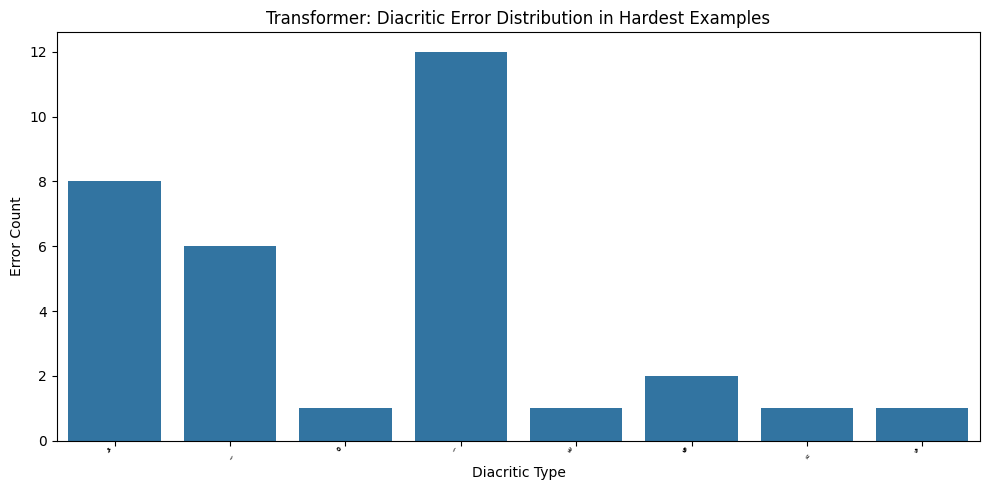


As shown in the Figure the most errors happend in فتحه


# In hardest examples BiLSTM was better than transformer

In [1]:
# Assuming your model is already defined as shown in the code
transformer_model = TransformerDiacritizationModel(
    vocab_size=73,
    diacritic_size=199,
    embedding_dim=256,
    nhead=8,
    num_encoder_layers=6,
    dim_feedforward=1024,
    dropout=0.1
).to(device)

model_path = "/content/best_transformer_model.pt"
transformer_model.load_state_dict(torch.load(model_path))

transformer_model.eval()


subset_test_dataset = torch.utils.data.Subset(test_dataset, list(range(10)))



# Test Transformer model on hardest examples
transformer_hardest = test_model(transformer_model, test_dataset, char_to_idx, diacritic_to_idx, idx_to_char, idx_to_diacritic, device, num_examples=5)

NameError: name 'TransformerDiacritizationModel' is not defined

# Fine-Tuning AraBERT for Arabic Diacritization

In this section, I fine-tuned the **AraBERTv2** model (`aubmindlab/bert-base-arabertv2`) for the task of Arabic diacritization. AraBERT is a Transformer-based encoder model, pretrained on large Arabic corpora, making it well-suited for language-specific tasks like diacritic restoration.

---

#### Setup and Training

- **Model**: `aubmindlab/bert-base-arabertv2` (encoder-only Transformer)
- **Task**: Token classification for diacritic restoration
- **Loss Function**: CrossEntropyLoss (ignores `<PAD>`)
- **Optimizer**: AdamW (lr=2e-5)
- **Precision**: bfloat16 enabled
- **Frozen Layers**: First 10 encoder layers to speed up training

To reduce overfitting and improve efficiency, the lower layers of the encoder were frozen during training.

---

#### Performance and Limitations

- **Epoch 1 Accuracy**: `92.46%` — strong early performance with high potential for further improvement
- **Final Accuracy (after Epoch 2)**: `94.26%`
- **Training Time**: Approximately **8 hours** for just **2 epochs** on Google Colab with an A100 GPU
- **Note**: Training was stopped early due to compute constraints

Despite limited compute access, the model showed promising results early on. Given more resources, it is likely the accuracy would continue to improve.
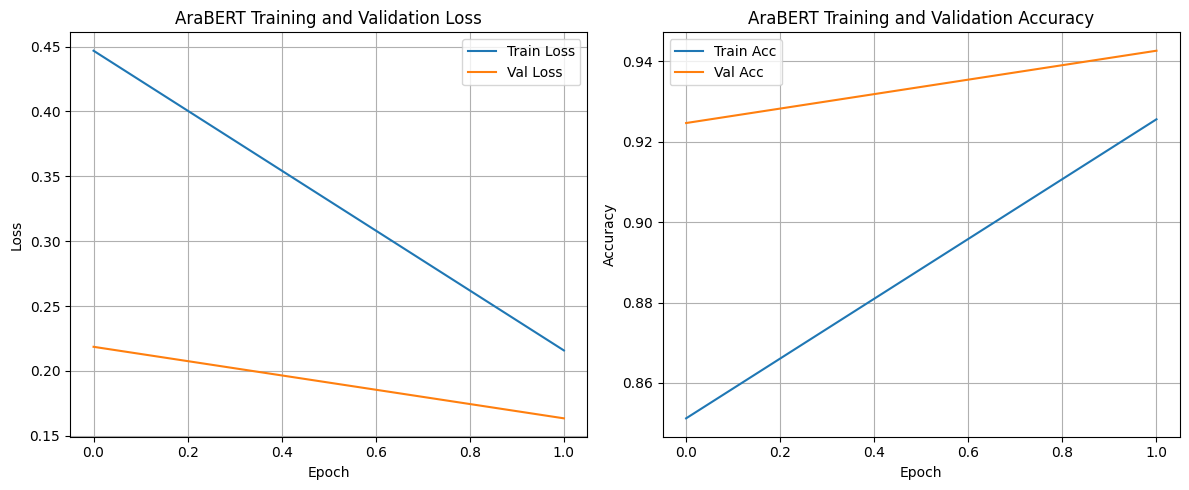
---

#### Comparison

- **AraBERT Fine-Tuned Accuracy**: `94.26%` (Validation accuracy)
- BiLSTM : `97.24%` outperform fine-tuned arabert (Validation accuracy)
- **Custom Transformer Trained from Scratch**: `97.33%` — outperformed AraBERT significantly
(Validation accuracy)

While AraBERT benefits from rich pretraining, the custom Transformer—designed and trained specifically for this task—demonstrated better performance.

---

#### Conclusion

AraBERT offers a strong pretrained baseline for Arabic diacritization, especially when labeled data is limited. However, a tailored Transformer trained from scratch achieved higher accuracy and should be considered when sufficient resources are available.


In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
from torch.optim import AdamW
import torch
from torch import nn

# Define model and tokenizer
model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
arabert_model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(diacritic_to_idx),
    ignore_mismatched_sizes=True
).to(device)

# Configure mixed precision
arabert_model.config.use_bfloat16 = True

# Data quality check: Verify tokenizer and vocabulary alignment
sample_text = df['undiacritized'].iloc[0][:50]
encoded = tokenizer(sample_text, return_tensors='pt', padding=True, truncation=True, max_length=512)
decoded = tokenizer.decode(encoded['input_ids'][0], skip_special_tokens=True)
print(f"Sample Text: {sample_text}")
print(f"Decoded Tokens: {decoded}")
print(f"Number of Diacritic Labels: {len(diacritic_to_idx)}")

# Freeze lower layers
for param in arabert_model.bert.encoder.layer[:10].parameters():
    param.requires_grad = False

Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sample Text: الماء الذي ينجس والذي لا ينجس ( قال الشافعي رحمه ا
Decoded Tokens: الماء الذي ينجس والذي لا ينجس ( قال الشافعي رحمه ا
Number of Diacritic Labels: 199



Fine-tuning AraBERT model...


Epoch 1/2 - Validation: 100%|██████████| 1127/1127 [12:05<00:00,  1.55it/s]



Epoch 1/2:
Train Loss: 0.4468, Train Acc: 85.12%
Val Loss: 0.2186, Val Acc: 92.46%
Saved best AraBERT model to: /content/drive/MyDrive/best_arabert_model.pt


Epoch 2/2 - Validation: 100%|██████████| 1127/1127 [12:05<00:00,  1.55it/s]



Epoch 2/2:
Train Loss: 0.2158, Train Acc: 92.56%
Val Loss: 0.1634, Val Acc: 94.26%
Saved best AraBERT model to: /content/drive/MyDrive/best_arabert_model.pt


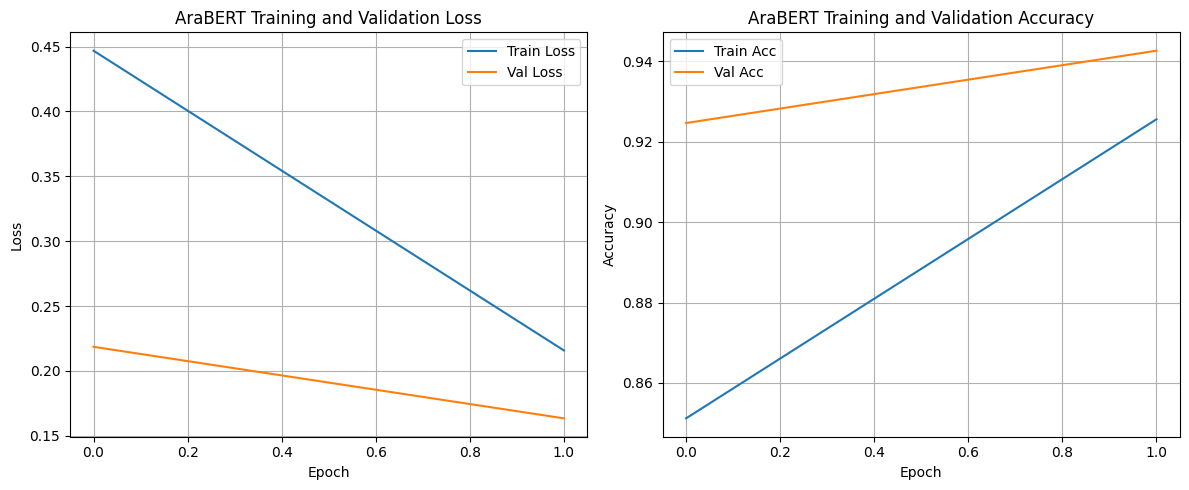

In [ ]:
def train_arabert_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    best_model_path = '/content/drive/MyDrive/best_arabert_model.pt'

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs.transpose(1, 2), labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            mask = labels != diacritic_to_idx['<PAD>']
            preds = outputs.argmax(dim=-1)
            train_correct += ((preds == labels) & mask).sum().item()
            train_total += mask.sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(inputs).logits
                loss = criterion(outputs.transpose(1, 2), labels)

                val_loss += loss.item()
                mask = labels != diacritic_to_idx['<PAD>']
                preds = outputs.argmax(dim=-1)
                val_correct += ((preds == labels) & mask).sum().item()
                val_total += mask.sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total if val_total > 0 else 0

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best AraBERT model to: {best_model_path}")

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('AraBERT Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('AraBERT Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/arabert_training_history.png')  
    plt.show()

    return history


# Initialize training components
criterion = nn.CrossEntropyLoss(ignore_index=diacritic_to_idx['<PAD>'])
optimizer = AdamW(arabert_model.parameters(), lr=2e-5)

# Train the model
print("\nFine-tuning AraBERT model...")
history = train_arabert_model(arabert_model, train_loader, val_loader, criterion, optimizer, num_epochs=2)


Loaded best AraBERT model for testing...
Testing on 53754 samples (10.0% of test dataset)


Finding hardest AraBERT examples (30% sample): 100%|██████████| 53754/53754 [07:46<00:00, 115.31it/s]



AraBERT Model: Hardest Examples (30% Test Data)

Example 1 (Index 169151, Errors: 86):
Input Text: وإنما كان يصح الأخذ برواية القعنبي, ويحيى, لو أمكن أن يكونا خبرين اثنين عن موطئين مختلفين وقولنا ههنا هو قول الشافعي وأبي سليمان
True Diacritized Text: وإنما كان يصح الأخذ برواية القعنبي, ويحيى, لو أمكن أن يكونا خبرين اثنين عن موطئين مختلفين وقولنا ههنا هو قول الشافعي وأبي سليمان
Predicted Diacritized Text: وَإِنَّمَا كَانَ يَصِحُّ الأَخْذُ بِرِوَايَةِ الْقَعْنَبِيِّ, وَيَحْيَى, لَوْ أَمْكَنَ أَنْ يَكُونَا خَبِرِينَ اثْنَيْنِ عَنْ مُوَطِئِيْنَ مُخْتَلِفِيْنَ وَقَوْلُنَا هَهُنَا هُوَ قَوْلُ الشَّافِعِيِّ وَأَبِي سُلَيْمَانَ

Example 2 (Index 206984, Errors: 82):
Input Text: يعه حتى ننقله من مكانه ومن طريق مسلم أنا أبو بكر بن أبي شيبة أنا عبد الأعلى عن معمر عن الزهري عن سالم بن عبد الله بن عمرعن ابن ع
True Diacritized Text: يعه حتى ننقله من مكانه ومن طريق مسلم أنا أبو بكر بن أبي شيبة أنا عبد الأعلى عن معمر عن الزهري عن سالم بن عبد الله بن عمرعن ابن ع
Predicted Diacritized Text: يَعَهُ حَتّ

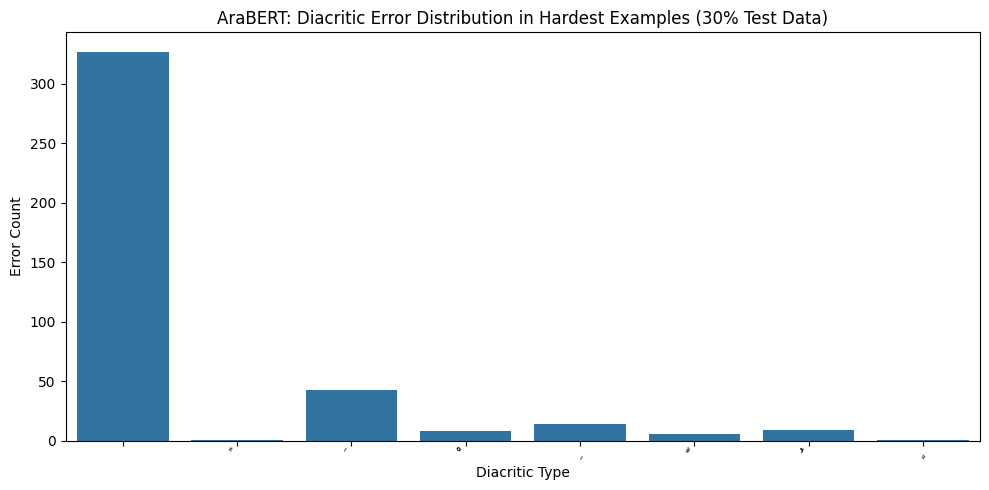

In [ ]:
import random
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# Function to reconstruct text with diacritics
def reconstruct_text(chars, diacritics):
    """Reconstruct text by combining characters and diacritics."""
    result = []
    for char, diac in zip(chars, diacritics):
        result.append(char)
        if diac and diac != '<NONE>':
            result.append(diac)
    return ''.join(result)

# Function to test AraBERT on hardest examples (30% of test data)
def test_arabert_hardest(model, test_dataset, char_to_idx, diacritic_to_idx, idx_to_char, idx_to_diacritic, device, num_examples=5, sample_ratio=0.1, random_seed=42):
    """Identify and analyze the hardest examples for AraBERT using a 30% sample of the test dataset."""
    model.eval()
    errors = []

    # Set random seed for reproducibility
    random.seed(random_seed)

    # Sample 30% of test dataset indices
    total_size = len(test_dataset)
    sample_size = int(sample_ratio * total_size)
    sampled_indices = random.sample(range(total_size), sample_size)
    print(f"Testing on {sample_size} samples ({sample_ratio*100:.1f}% of test dataset)")

    with torch.no_grad():
        for idx in tqdm(sampled_indices, desc="Finding hardest AraBERT examples (30% sample)"):
            sample = test_dataset[idx]
            input_ids = sample['input_ids'].unsqueeze(0).to(device)
            labels = sample['labels'].numpy()

            outputs = model(input_ids).logits
            preds = outputs.argmax(dim=-1).squeeze(0).cpu().numpy()

            mask = labels != diacritic_to_idx['<PAD>']
            error_count = ((preds != labels) & mask).sum().item()

            errors.append((idx, error_count, input_ids.squeeze().cpu().numpy(), labels, preds))

    # Sort errors to find hardest examples
    errors.sort(key=lambda x: x[1], reverse=True)
    hardest_examples = errors[:num_examples]

    # Print hardest examples
    print("\nAraBERT Model: Hardest Examples (30% Test Data)")
    for i, (idx, error_count, input_ids, labels, preds) in enumerate(hardest_examples, 1):
        chars = [idx_to_char.get(id, '<UNK>') for id in input_ids if id != char_to_idx['<PAD>']]
        true_diacritics = [idx_to_diacritic.get(id, '<NONE>') for id in labels if id != diacritic_to_idx['<PAD>']]
        pred_diacritics = [idx_to_diacritic.get(id, '<NONE>') for id in preds if id != diacritic_to_idx['<PAD>']]

        input_text = ''.join(chars)
        true_text = reconstruct_text(chars, true_diacritics)
        pred_text = reconstruct_text(chars, pred_diacritics)

        print(f"\nExample {i} (Index {idx}, Errors: {error_count}):")
        print(f"Input Text: {input_text}")
        print(f"True Diacritized Text: {true_text}")
        print(f"Predicted Diacritized Text: {pred_text}")

    # Plot error distribution
    error_diacritics = Counter()
    for _, _, _, labels, preds in hardest_examples:
        mask = labels != diacritic_to_idx['<PAD>']
        for true_id, pred_id in zip(labels[mask], preds[mask]):
            if true_id != pred_id:
                true_diac = idx_to_diacritic.get(true_id, '<NONE>')
                error_diacritics[true_diac] += 1

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(error_diacritics.keys()), y=list(error_diacritics.values()))
    plt.title('AraBERT: Diacritic Error Distribution in Hardest Examples (30% Test Data)')
    plt.xlabel('Diacritic Type')
    plt.ylabel('Error Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/arabert_error_distribution_30percent.png')
    plt.show()

    return hardest_examples

arabert_model.load_state_dict(torch.load('/content/drive/MyDrive/best_arabert_model.pt'))
print("\nLoaded best AraBERT model for testing...")

arabert_hardest = test_arabert_hardest(
    model=arabert_model,
    test_dataset=test_dataset,
    char_to_idx=char_to_idx,
    diacritic_to_idx=diacritic_to_idx,
    idx_to_char=idx_to_char,
    idx_to_diacritic=idx_to_diacritic,
    device=device,
    num_examples=5,
    sample_ratio=0.1,
    random_seed=42
)

# corporation  between all trained models
BLSTM , fine tuned Arabert , myown tranasformer
plot and text in markdown with examples each

   """
    Compare multiple models on the same dataset.

    Args:
        models_dict (dict): {'Model Name': model_object}
        dataset (Dataset): PyTorch-style dataset for evaluation
        idx_to_char (dict): index to character mapping
        idx_to_diacritic (dict): index to diacritic mapping
        diacritic_to_idx (dict): diacritic to index mapping
        device (torch.device): device to run models on
        num_examples (int): number of hardest examples to visualize
    """

In [ ]:
from collections import defaultdict
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def compare_models(models_dict, dataset, idx_to_char, idx_to_diacritic, diacritic_to_idx, device, num_examples=3):

    results = defaultdict(list)

    for model_name, model in models_dict.items():
        correct = 0
        total = 0
        all_examples = []

        with torch.no_grad():
            for i in tqdm(range(len(dataset)), desc=f"Evaluating {model_name}"):
                sample = dataset[i]
                input_ids = sample['input_ids'].unsqueeze(0).to(device)
                labels = sample['labels'].cpu().numpy()

                # Get the output from the model, it can be raw tensor or CustomOutputClass
                outputs = model(input_ids)
                # Access logits based on the output type
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs

                preds = logits.argmax(dim=-1).squeeze(0).cpu().numpy()

                mask = labels != diacritic_to_idx['<PAD>']
                correct += ((preds == labels) & mask).sum().item()
                total += mask.sum().item()

                error_count = ((preds != labels) & mask).sum().item()
                all_examples.append((error_count, input_ids.squeeze(0).cpu().numpy(), labels, preds))

        accuracy = correct / total if total > 0 else 0
        print(f"{model_name} Accuracy: {accuracy:.2%}")
        results['Model'].append(model_name)
        results['Accuracy'].append(accuracy)

        # Store top-N hardest examples
        all_examples.sort(reverse=True, key=lambda x: x[0])
        print(f"\nHardest {num_examples} examples for {model_name}:")
        for idx, (err_count, inp_ids, labels, preds) in enumerate(all_examples[:num_examples]):
            chars = [idx_to_char.get(id, '') for id in inp_ids if id in idx_to_char]
            true_diac = [idx_to_diacritic.get(id, '') for id in labels if id in idx_to_diacritic]
            pred_diac = [idx_to_diacritic.get(id, '') for id in preds if id in idx_to_diacritic]

            def reconstruct(chars, diacs):
                return ''.join(c + (d if d != '<NONE>' else '') for c, d in zip(chars, diacs))

            print(f"\nExample {idx+1} (Errors: {err_count}):")
            print("Input Text:           ", ''.join(chars))
            print("True Diacritized:     ", reconstruct(chars, true_diac))
            print("Predicted Diacritized:", reconstruct(chars, pred_diac))

    # Plot comparison bar chart
    plt.figure(figsize=(8, 4))
    plt.bar(results['Model'], results['Accuracy'], color='skyblue')
    plt.ylim(0.0, 1.0)
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Comparison")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig("model_comparison.png")
    plt.show()

    return results

# push best model to Hugging face (Transformer from scracth)
You can fine it from here :

[Arabic Diacritization Transformer ](https://huggingface.co/hatimalhomid/arabic-diacritization-transformer)

In [6]:
from huggingface_hub import HfApi, Repository, create_repo
from pathlib import Path
import shutil

username = "hatimalhomid"
repo_name = "arabic-diacritization-transformer"
repo_id = f"{username}/{repo_name}"

token = "HUGGINGFACETOKE"

api = HfApi()
try:
    create_repo(repo_id=repo_id, private=False, token=token, exist_ok=True)
    print(f"Repository '{repo_id}' created or already exists.")
except Exception as e:
    print(f"Error creating repository: {e}")

local_repo_path = Path(f"/content/{repo_name}")
try:
    repo = Repository(local_dir=local_repo_path, clone_from=repo_id, token=token)
    print("Repository cloned successfully.")
except Exception as e:
    print(f"Error cloning repository: {e}")
    local_repo_path.mkdir(parents=True, exist_ok=True)
    repo = Repository(local_dir=local_repo_path, token=token)
    repo.git_init()
    print("Initialized a new local repository using repo.git_init().")

model_path = "/content/best_transformer_model.pt"
shutil.copy(model_path, local_repo_path / "pytorch_model.bin")
print("Model file copied successfully.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/hatimalhomid/arabic-diacritization-transformer into local empty directory.


Repository 'hatimalhomid/arabic-diacritization-transformer' created or already exists.
Repository cloned successfully.
Model file copied successfully.


# Attempted Use of ALLaM-7B for Arabic Diacritization

In this section, I explored the potential of using **ALLaM-7B**, a large language model tailored for Arabic, for the task of diacritization.

---

#### Model Overview

- **Model Name**: ALLaM-7B-Instruct-preview  
- **Architecture**: Decoder-only (Causal Language Model)  
- **Tokenizer**: SentencePiece tokenizer with Arabic support  
- **Parameters**: ~7 billion  
- **Pretraining**: Trained on a large-scale Arabic corpus, including text with diacritics (ḥarakāt)

ALLaM was loaded using **4-bit quantization** with NF4 to reduce memory usage and enable running the model on limited hardware. Additionally, **LoRA (Low-Rank Adaptation)** was applied to facilitate efficient fine-tuning on downstream tasks like diacritization.

---

#### Limitations

Unfortunately, due to hardware constraints, I was **unable to fully train or fine-tune** ALLaM on the diacritization dataset. The model's size and resource requirements exceeded my available compute capacity.

---

#### Potential

Despite not completing training, I believe ALLaM shows **strong potential** for Arabic diacritization for the following reasons:

- It is a **decoder-based Transformer** optimized for generation tasks like this.
- It was pretrained on a **massive Arabic dataset**, which includes a large amount of text with diacritics.
- It can benefit from **instruction tuning**, making it suitable for structured tasks like restoring missing diacritics when prompted appropriately.

---

#### Sample Tokenization Check

A preliminary test was conducted to verify proper tokenization and alignment with input Arabic text. The tokenizer handled the sample correctly, preserving Arabic characters as expected.

---

#### Conclusion

With sufficient computational resources, training or fine-tuning ALLaM on a diacritization dataset could yield high-quality results. Future work could involve distributed training, using parameter-efficient fine-tuning techniques at scale, or leveraging cloud-based resources to fully utilize the model's capabilities.


In [ ]:
# Import necessary libraries
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
import torch

# Define quantization config for 4-bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load ALLaM model and tokenizer
model_name = "ALLaM-AI/ALLaM-7B-Instruct-preview"
allam_tokenizer = AutoTokenizer.from_pretrained(model_name)
allam_tokenizer.pad_token = allam_tokenizer.eos_token
allam_tokenizer.padding_side = "right"

allam_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16
)

# Configure LoRA
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
allam_model = get_peft_model(allam_model, lora_config)

sample_text = df['undiacritized'].iloc[0][:50]
encoded = allam_tokenizer(sample_text, return_tensors='pt', padding=True, truncation=True, max_length=512)
decoded = allam_tokenizer.decode(encoded['input_ids'][0], skip_special_tokens=True)
print(f"Sample Text: {sample_text}")
print(f"Decoded Tokens: {decoded}")
print(f"Model Parameters: {allam_model.num_parameters()/1e9:.2f}B")

In [ ]:
def test_allam_hardest(model, tokenizer, test_dataset, device, num_examples=5):
    model.eval()
    errors = []

    with torch.no_grad():
        for idx in tqdm(range(len(test_dataset)), desc="Finding hardest ALLaM examples"):
            sample = test_dataset[idx]
            undiacritized = ''.join([idx_to_char.get(id, '<UNK>') for id in sample['input_ids'].numpy() if id != char_to_idx['<PAD>']])
            true_diacritized = sample['text']

            prompt = f"Add diacritics to the following Arabic text: {undiacritized}\nOutput: "
            inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)

            outputs = model.generate(**inputs, max_length=512)
            pred_diacritized = tokenizer.decode(outputs[0], skip_special_tokens=True).split("Output: ")[-1].strip()

            true_chars = list(true_diacritized)
            pred_chars = list(pred_diacritized)
            error_count = sum(1 for t, p in zip(true_chars, pred_chars) if t != p)

            errors.append((idx, error_count, undiacritized, true_diacritized, pred_diacritized))

    errors.sort(key=lambda x: x[1], reverse=True)
    hardest_examples = errors[:num_examples]

    print("\nALLaM-7B-Instruct: Hardest Examples")
    for i, (idx, error_count, undiacritized, true_diacritized, pred_diacritized) in enumerate(hardest_examples, 1):
        print(f"\nExample {i} (Index {idx}, Errors: {error_count}):")
        print(f"Input Text: {undiacritized}")
        print(f"True Diacritized Text: {true_diacritized}")
        print(f"Predicted Diacritized Text: {pred_diacritized}")

    # Error distribution (character-level)
    error_chars = Counter()
    for _, _, _, true_text, pred_text in hardest_examples:
        for t, p in zip(true_text, pred_text):
            if t != p and t in diacritic_to_idx:
                error_chars[t] += 1

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(error_chars.keys()), y=list(error_chars.values()))
    plt.title('ALLaM-7B-Instruct: Diacritic Error Distribution in Hardest Examples')
    plt.xlabel('Diacritic Type')
    plt.ylabel('Error Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('allam_error_distribution.png')
    plt.show()

    return hardest_examples

allam_model = AutoModelForCausalLM.from_pretrained(
    "best_allam_model",
    quantization_config=BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4"),
    device_map="auto"
)
allam_tokenizer = AutoTokenizer.from_pretrained("best_allam_model")

print("\nTesting ALLaM-7B-Instruct on hardest examples...")
allam_hardest = test_allam_hardest(allam_model, allam_tokenizer, test_dataset, device, num_examples=5)